In [1]:
import squidpy as sq
import scanpy as sc
from CCST import train_DGI, PCA_process, Umap
from utilities import build_graph
import numpy as np
import pandas as pd
import os
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder 
from sklearn.cluster import KMeans
from torch_geometric.data import DataLoader

seed = 2022

/home/ubuntu/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 对squidpy中集成的10X Visium数据集进行处理

/home/ubuntu/.local/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


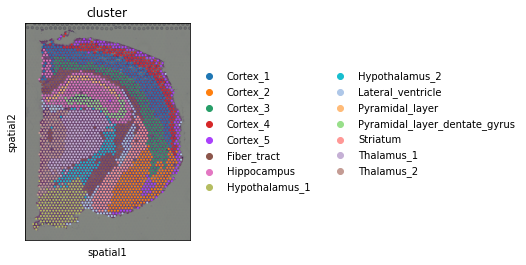

In [2]:
adata = sq.datasets.visium_hne_adata(path='../dataset/visium_hne.h5ad')
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pl.spatial(adata, color=['cluster'])

In [3]:
data = build_graph(adata, radius=250, lamb=0.45)
data_loader = DataLoader([data], batch_size=1)
adata.obsm['CCST'] = train_DGI(data_loader, len(data.x[0]), 128, 1500, 1e-6, seed)
adata.obsm['CCST'] 

/home/ubuntu/.local/lib/python3.8/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


torch.Size([2688, 3000])


100%|██████████| 1500/1500 [08:41<00:00,  2.88it/s]

Training time in seconds:  521


array([[-0.15425816,  3.3193903 ,  0.59926045, ..., -0.19506471,
         2.7546706 ,  0.12029379],
       [-0.13903494,  2.595563  ,  0.83795893, ..., -0.11453182,
         2.2037506 ,  0.00375837],
       [ 0.60613674,  2.5292492 ,  0.5261588 , ...,  0.5779465 ,
         2.7109618 , -0.12875092],
       ...,
       [ 0.3396362 ,  2.344643  ,  0.48192355, ...,  0.43465248,
         2.7763588 , -0.10371747],
       [ 0.26687235,  2.8637905 ,  0.46376738, ...,  0.5314633 ,
         2.5070107 , -0.16561821],
       [-0.18669719,  3.1167057 ,  0.9681783 , ..., -0.13265863,
         2.6619577 , -0.02223263]], dtype=float32)

In [4]:
adata.obsm['CCST_pca'] = PCA_process(adata.obsm['CCST'], 50)
adata.obsm['CCST_pca']

Shape of data to PCA: (2688, 128)
Shape of data output by PCA: (2688, 50)
PCA recover: 0.99908495


array([[-4.2793155e+00, -1.6409735e-01, -3.1610125e-01, ...,
         9.5650544e-03, -2.7501553e-02, -2.6868882e-03],
       [-4.3631463e+00, -5.8327880e-02, -4.7814990e-03, ...,
        -4.3991841e-02, -5.1804665e-02, -7.5517386e-02],
       [ 3.8958349e+00,  1.7843343e+00, -4.5849207e-01, ...,
         3.5626207e-02, -1.5710253e-02, -4.7132526e-02],
       ...,
       [ 3.1448913e+00,  2.1113536e+00, -1.8652497e-01, ...,
        -2.0785261e-02, -2.3593901e-02, -2.5656246e-02],
       [ 3.6061788e+00, -6.7755729e-01, -1.2808913e+00, ...,
        -1.2265440e-02, -2.4933549e-02, -4.2054918e-02],
       [-4.7954078e+00,  1.4788634e-03, -1.9161788e-01, ...,
         2.2296216e-02, -1.1310320e-02,  2.8824143e-02]], dtype=float32)

In [5]:
k_means = KMeans(n_clusters=15, random_state=seed)
k_means.fit(adata.obsm['CCST_pca'])
adata.obs['kmeans'] = k_means.predict(adata.obsm['CCST_pca'])
label = LabelEncoder().fit_transform(adata.obs['cluster'])
pred = LabelEncoder().fit_transform(adata.obs['kmeans'])
metrics.adjusted_rand_score(label, pred) 

0.36331785943185657

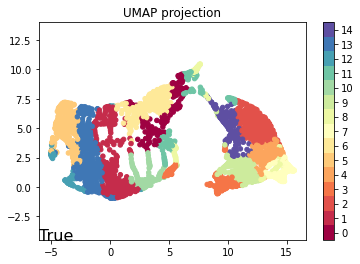

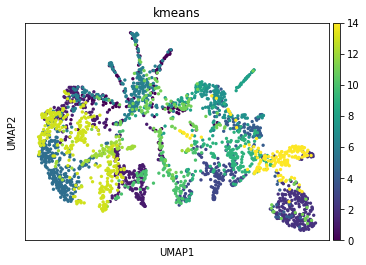

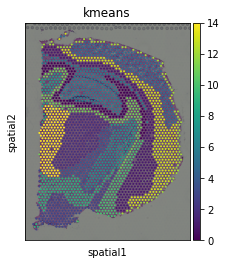

In [6]:
Umap(adata.obsm['CCST_pca'], adata.obs['kmeans'], 15, True, seed)
sc.pl.umap(adata, color=['kmeans'])
sc.pl.spatial(adata, color=['kmeans'])